University of Helsinki, Master's Programme in Mathematics and Statistics  
MAST32001 Computational Statistics, Autumn 2023  
Luigi Acerbi  
Based on notebook by Antti Honkela

# Lecture 12: MCMC and gradients 1: Hamiltonian Monte Carlo

Background reading: please see Chapter 13 of the "Course notes" available in Moodle.

## Test cases

Throughout the lecture, we will consider the following examples as test cases:
1. Circle: $ \log p_1(x) = -20 \cdot (\|x\|_2-10)^2 $
2. Correlated 2-$D$ multivariate normal: $ p_2(x) = \mathcal{N}(x ;\; \mathbf{0}, \Sigma_2) $, where $ \Sigma_2 = \begin{pmatrix} 1 & \rho \\ \rho & 1 \end{pmatrix}$ with $\rho = 0.998$
3. 20-$D$ normal: $ p_3(x) = \mathcal{N}(x ;\; \mathbf{0}, \Sigma_3) $, where $\Sigma_3 = \mathrm{diag}(0.05^2, 0.1^2, \dots, 0.95^2, 1.00^2)$ and $\mathbf{0}$ is a 20-$D$ zero vector.

*Notes*: 
- Assuming proposals use a $\sigma^2 I_D$ covariance, all considered algorithms are rotation invariant. Example 3 thus represents any high-dimensional normal with this particular range of scales for different directions.
- To assess the quality of the approximation for $p_3$, it is a good idea to plot the means and standard deviations of the samples in each dimension and compare those with the ground truth.

In [1]:
%matplotlib inline
import numpy as np
import numpy.random as npr
import matplotlib.pyplot as plt
import numpy.linalg as npl

def circle(x):
    """Circle target log pdf."""
    return -20*(np.sqrt(np.sum(x**2))-10)**2

def correlated_normal(x, rho=0.998):
    """Correlated normal target log pdf."""
    Sigma = np.array([[1.0, rho],[rho, 1.0]])
    return -0.5*(x.T @ npl.solve(Sigma, x))

def big_normal(x):
    """Big multivariate normal target log pdf."""
    return -0.5*np.sum(x**2 / (np.arange(1, 21)/20)**2)

## 1. MCMC videos (Optional)

Creating videos of the MCMC methods at work can be very useful to see how they perform. Try out the code below to visualise the performance of different MCMC algorithms by plotting a sequence of samples overlaid over a contour plot of the target. 

- **Installation**: To make this work with an Anaconda distribution, if you do not already have the necessary packages, you can install the necessary packages with `conda install ffmpeg` (or `conda install -c conda-forge ffmpeg`) from the command line. 
- If you do not manage to install the necessary packages on your computer, you can just follow the presentation in class or try with the computer lab Linux computers (or just skip this).
- If it works, test the video plots with the standard Metropolis-Hastings sampling of the example target distributions shown above.

In [2]:
def d_mhsample(theta0, n, log_target, drawproposal, log_proposal=lambda x,y: 0, return_accrate=False):
    """
    Metropolis-Hastings sampler for n samples from starting point theta0 in arbitrary dimension.
    log_target is the log of the target pdf, and 
    drawproposal samples from the proposal (assumed symmetric).
    A warm up phase of n samples is run beforehand (these samples are not returned).
    """    
    theta = theta0
    d = len(theta0)
    accepts = 0
    lp = log_target(theta)
    thetas = np.zeros([n, d])
    for i in range(2*n):
        theta_prop = drawproposal(theta)
        l_prop = log_target(theta_prop)
        if np.log(npr.rand()) < l_prop - lp + log_proposal(theta_prop, theta) - log_proposal(theta, theta_prop):
            theta = theta_prop
            lp = l_prop
            # Record acceptance rate after burnin
            if i >= n:
                accepts += 1
        # Record samples after burnin
        if i >= n:
            thetas[i-n] = theta
    if return_accrate:
        return thetas[len(thetas)//2:], accepts/n
    else:
        print('Acceptance rate:', accepts/n)
        return thetas[len(thetas)//2:]

def plot_results(samples, name='target'):
    """Plot MCMC results."""
    plt.plot(samples[:,0], samples[:,1], '.')
    plt.xlabel(r'$x_0$')
    plt.ylabel(r'$x_1$')
    plt.title(r'MCMC samples from the ' + name + ' distribution')
    plt.show()
    print('Mean: {}'.format(np.mean(samples, 0)))
    print('Std: {}'.format(np.std(samples, 0))) 

Acceptance rate: 0.19416


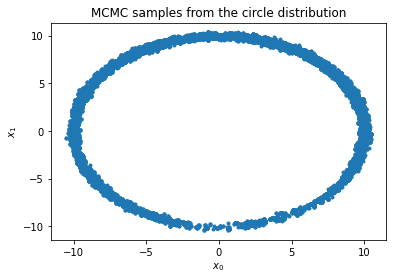

Mean: [0.98744183 3.5366117 ]
Std: [7.19798129 5.89420224]


In [3]:
# 1
samples1 = d_mhsample(np.zeros(2), 50000, circle, lambda x: x+npr.normal(size=2))
plot_results(samples1, 'circle')

Acceptance rate: 0.2658333333333333


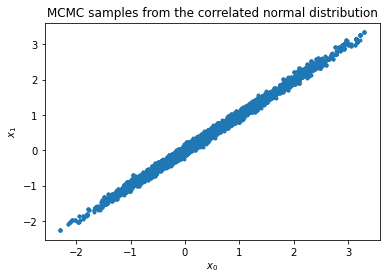

Mean: [0.46394744 0.46360319]
Std: [0.90116608 0.90120727]
Correlation coefficient rho: 0.9975724351213671


In [4]:
#2
samples2 = d_mhsample(np.zeros(2), 30000, correlated_normal, lambda x: x+0.2*npr.normal(size=2))
plot_results(samples2, 'correlated normal')
print('Correlation coefficient rho: {}'.format(np.corrcoef(samples2.T)[0,1]))

Acceptance rate: 0.29672


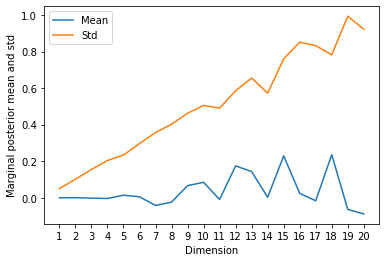

In [5]:
#3
samples3 = d_mhsample(np.zeros(20), 50000, big_normal, lambda x: x+0.1*npr.normal(size=20))
plt.plot(np.arange(1, 21), np.mean(samples3, 0),label='Mean')
plt.plot(np.arange(1, 21), np.std(samples3, 0),label='Std')
plt.xticks(np.arange(1,21))
plt.xlabel('Dimension')
plt.ylabel('Marginal posterior mean and std')
plt.legend()
plt.show()

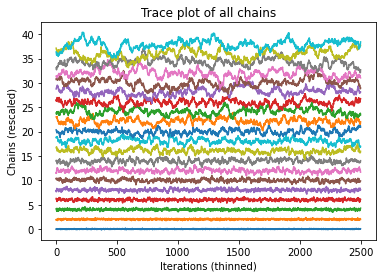

In [6]:
# Handy trick for plotting the samples of the last example in parallel
plt.plot(samples3[::10] + 2*np.arange(20))
plt.xlabel('Iterations (thinned)')
plt.ylabel('Chains (rescaled)')
plt.title('Trace plot of all chains')
plt.show()

In [7]:
from IPython.display import HTML
from matplotlib import animation, rc

def make_animation(samples,xlims,ylims,target,name):
    """Make animation (it works only with 2D target)."""

    # First set up the figure, the axis, and the plot element we want to animate
    fig, ax = plt.subplots()

    ax.set_xlim(xlims)
    ax.set_ylim(ylims)

    x = np.linspace(xlims[0], xlims[-1], 100)
    y = np.linspace(ylims[0], ylims[-1], 100)
    X, Y = np.meshgrid(x, y)

    Z = np.zeros((len(x), len(y)))
    # Need to use a for loop here because f() does not support vectorised evaluation
    for i, x_i in enumerate(x):
        for j, y_j in enumerate(y):
            Z[i,j] = target(np.array([x_i,y_j]))

    plt.contour(X, Y, np.log(np.abs(Z.T)))
    plt.xlabel(r'$x_0$')
    plt.ylabel(r'$x_1$')
    plt.title(r'MCMC sampling from the ' + name + ' distribution')
    pts, = ax.plot([], [], 'r', lw=2)

    # initialization function: plot the background of each frame
    def init():
        pts.set_data([], [])
        return (pts,)
    
    frames_max=1000
    samples = samples[0:int(np.minimum(samples.shape[0],frames_max))]

    # animation function. This is called sequentially
    def animate(i, trace_len=20):
        idx = np.round(np.linspace(0,samples.shape[0],frames_max))
        pts.set_data(samples[np.max([0, int(idx[i])-trace_len]):int(idx[i])+1,0], samples[np.max([0, int(idx[i])-trace_len]):int(idx[i])+1,1])
        # pts.set_data(samples[np.max([0, 10*i-500]):10*i:5,0], samples[np.max([0, 10*i-500]):10*i:5,1])
        return (pts,)

    # call the animator. blit=True means only re-draw the parts that have changed.
    return animation.FuncAnimation(fig, animate, init_func=init,
                                   frames=frames_max, interval=20, blit=True)

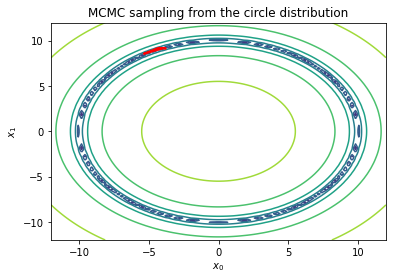

In [8]:
# 1
xlims = (-12, 12)
ylims = (-12, 12)
anim = make_animation(samples1,xlims,ylims,circle,'circle')
HTML(anim.to_html5_video())

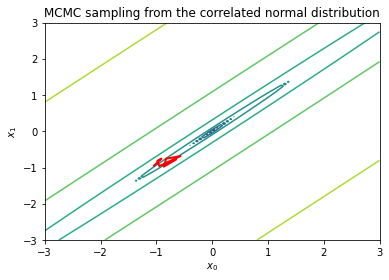

In [9]:
# 2
xlims = (-3, 3)
ylims = (-3, 3)
anim = make_animation(samples2,xlims,ylims,correlated_normal,'correlated normal')
HTML(anim.to_html5_video())

## 2. HMC sampling

Implement a HMC sampler and test it on the example models given above. Use `autograd` or PyTorch to evaluate the gradients of the target distributions.

As a starting point, here is a Python translation for a simple Hamiltonian Monte Carlo algorithm from Chapter 30 of MacKay's Information Theory, Inference, and Learning Algorithms (http://www.inference.org.uk/mackay/itprnn/ps/387.412.pdf), edited to use log-probabilities (higher is preferred) instead of energies (lower is preferred) as in the original:

``` {python}
g = gradF(x)  # set gradient using initial x
logP = target(x) # set log-target function too
for m in range(M): # collect M samples
    p = npr.normal(size=x.shape)  # initial momentum is Normal(0,1)
    H = p.T @ p / 2 - logP   # evaluate H(x,p)
    xnew = np.copy(x)
    gnew = np.copy(g)
    for l in range(L): # make L ‘leapfrog’ steps
        p = p + epsilon * gnew / 2   # make half-step in p
        xnew = xnew + epsilon * p    # make step in x
        gnew = gradF(xnew)           # find new gradient
        p = p + epsilon * gnew / 2   # make half-step in p
    logPnew = target(xnew)           # find new value of H
    # in theory we should now set p = -p to make the chain reversible,
    # but as we are not storing p values this makes no difference
    Hnew = p.T @ p / 2 - logPnew
    dH = Hnew - H    # Decide whether to accept, H = - log P, so need to flip sign in MH test
    if dH < 0 or np.log(npr.rand()) < -dH:
        g = gnew
        x = xnew
        logP = logPnew
```

*Notes*: 
- The sampler depends on the number of integration steps $L$ and step length $\epsilon$. We will consider their tuning in more detail in the next lecture. For now, you can manually find a small enough $\epsilon$ to get a reasonable acceptance rate (around 80% is theoretically optimal in certain conditions), trying different values of $L$.
- You can try manually tuning the parameters yourself. Assuming your sampler is correctly implemented, increasing $\epsilon$ typically leads to a gradual drop in the acceptance until at some point there is a catastrophic drop to 0.
- The HMC sampler differs from other MCMC samplers in that you typically need significantly fewer samples due to the low autocorrelation. 1000 is usually plenty and you can start with as few as 100. A critical quantity here is $\epsilon L$ which tells the effective length of the trajectories. Small $\epsilon L$ usually means more samples are needed.
- To get the gradients, you may have to re-implement the targets defined above after importing the correct autodiff libraries. In `autograd`, this is easily done using the import trick (e.g., `import autograd.numpy as np`, etc.). 

In [10]:
%matplotlib inline
import autograd.numpy as np
import autograd.numpy.random as npr
import autograd.numpy.linalg as npl
import autograd
import matplotlib.pyplot as plt

def circle(x):
    """Circle target log pdf."""
    return -20*(np.sqrt(np.sum(x**2))-10)**2

def correlated_normal(x, rho=0.998):
    """Correlated normal target log pdf."""
    Sigma = np.array([[1.0, rho],[rho, 1.0]])
    return -0.5*(x.T @ npl.solve(Sigma, x))

def big_normal(x):
    """Big multivariate normal target log pdf."""
    return -0.5*np.sum(x**2 / (np.arange(1, 21)/20)**2)

In [11]:
def hmc(theta0, M, target, epsilon0, L):
    """Hamiltonian Monte Carlo sampler."""
    thetas = np.zeros([M, len(theta0)])
    gradF = autograd.grad(target)
    theta = np.copy(theta0)
    g = gradF(theta)  # set gradient using initial theta
    logP = target(theta)  # set objective function too
    accepts = 0
    for m in range(2*M): # draw M samples after M warm-up iterations
        p = npr.normal(size=theta.shape)  # initial momentum is Normal(0,1)
        H = p.T @ p / 2 - logP   # evaluate H(x,p)
        thetanew = np.copy(theta)
        gnew = np.copy(g)
        for l in range(L): # make L 'leapfrog' steps
            epsilon = npr.uniform(0.8, 1.2) * epsilon0  # optional: randomise epsilon for improved theoretical convergence properties
            p = p + epsilon * gnew / 2   # make half-step in p
            thetanew = thetanew + epsilon * p    # make step in theta
            gnew = gradF(thetanew)           # find new gradient
            p = p + epsilon * gnew / 2   # make half-step in p
        logPnew = target(thetanew)   # find new value of H
        Hnew = p.T @ p / 2 - logPnew
        dH = Hnew - H    # Decide whether to accept
        if np.log(npr.rand()) < -dH:
            g = gnew
            theta = thetanew
            logP = logPnew
            accepts += 1
        if m >= M:
            thetas[m-M,:] = theta
    print('Acceptance rate:', accepts/(2*M))
    return thetas

Acceptance rate: 0.81


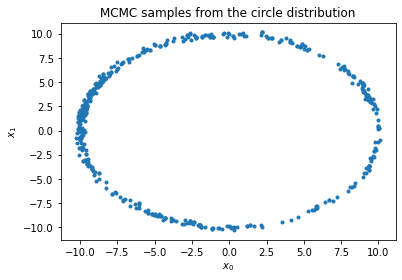

Mean: [-2.8128396   0.93305896]
Std: [7.08500384 6.41410906]


In [12]:
# 1
samples1 = hmc(np.array([2.0, 0.0]), 500, lambda theta: circle(theta), 0.2, 10)
plot_results(samples1,'circle')

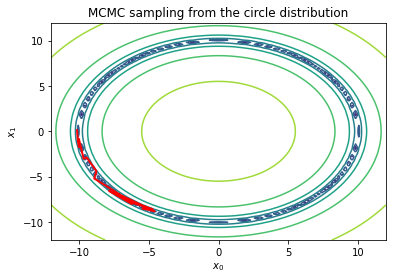

In [13]:
# 1 make video
xlims = (-12, 12)
ylims = (-12, 12)
anim = make_animation(samples1,xlims,ylims,circle,'circle')
HTML(anim.to_html5_video())

Acceptance rate: 0.998


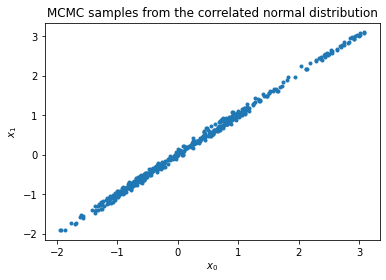

Mean: [0.19357629 0.20971922]
Std: [1.09257106 1.11132488]
Correlation coefficient rho: 0.9986811385229831


In [14]:
# 2
samples2 = hmc(np.array([0.0, 0.0]), 500, correlated_normal, 0.01, 30)
plot_results(samples2,'correlated normal')
print('Correlation coefficient rho: {}'.format(np.corrcoef(samples2.T)[0,1]))

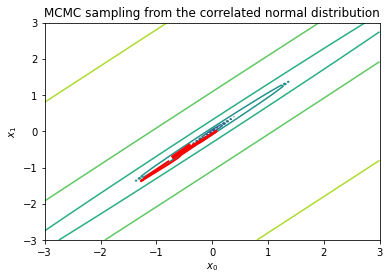

In [15]:
# 2 make video
xlims = (-3, 3)
ylims = (-3, 3)
anim = make_animation(samples2,xlims,ylims,correlated_normal,'correlated normal')
HTML(anim.to_html5_video())

Acceptance rate: 0.887


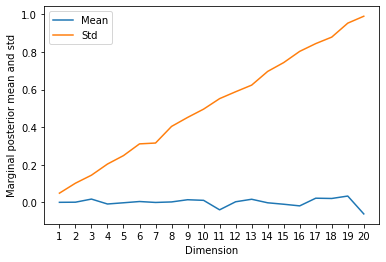

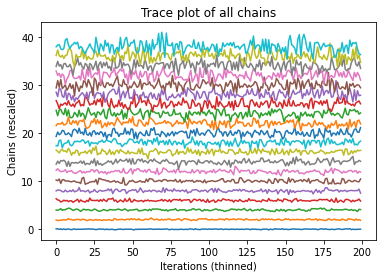

In [16]:
# 3
samples3 = hmc(np.zeros(20), 2000, big_normal, 0.05, 20)

plt.plot(np.arange(1, 21), np.mean(samples3, 0),label='Mean')
plt.plot(np.arange(1, 21), np.std(samples3, 0),label='Std')
plt.xticks(np.arange(1,21))
plt.xlabel('Dimension')
plt.ylabel('Marginal posterior mean and std')
plt.legend()
plt.show()

plt.plot(samples3[::10] + 2*np.arange(20))
plt.xlabel('Iterations (thinned)')
plt.ylabel('Chains (rescaled)')
plt.title('Trace plot of all chains')
plt.show()

### 2b. HMC sampling with PyTorch

In [ ]:
import torch
import autograd
import autograd.numpy as np

def circle_torch(x):
    """"""
    return x.pow(2).sum().sqrt().sub(10).pow(2).mul(-20)
    #return -20*(torch.sqrt(torch.sum(x**2))-10)**2

In [ ]:
%matplotlib inline
import torch
import matplotlib.pyplot as plt

dtype = torch.double
device = torch.device("cpu")

def runif(a, b):
    return (b-a)*torch.rand(1, dtype=dtype)+a

def hmc(x0, M, target, epsilon0, L):
    xs = torch.zeros([M, len(x0)], dtype=dtype)
    x = torch.tensor(x0, requires_grad=True, device=device, dtype=dtype)
    logP = target(x)  # set objective function too
    logP.backward()
    g = x.grad
    accepts = 0
    for m in range(2*M): # draw M samples after M warm-up iterations
        p = torch.normal(torch.zeros(x.shape, device=device, dtype=dtype))  # initial momentum is Normal(0,1)
        #p = torch.ones(x.shape, device=device, dtype=dtype)
        H = p.dot(p) / 2 - logP   # evaluate H(x,p)
        xnew = torch.tensor(x.data, requires_grad=True, device=device, dtype=dtype)
        gnew = torch.tensor(g, device=device, dtype=dtype)
        for l in range(L): # make L ‘leapfrog’ steps
            #epsilon = runif(0.8, 1.2) * epsilon0  # optional: randomise epsilon for improved theoretical convergence properties
            epsilon = epsilon0
            p.data += epsilon * gnew.data / 2   # make half-step in p
            xnew.data += epsilon * p.data          # make step in x
            if xnew.grad is not None:
                xnew.grad.zero_()
            logPnew = target(xnew)
            logPnew.backward()
            gnew = xnew.grad             # find new gradient
            with torch.no_grad():
                p.data += epsilon * gnew.data / 2   # make half-step in p
        logPnew = target(xnew)   # find new value of H
        Hnew = p.dot(p) / 2 - logPnew
        dH = Hnew - H    # Decide whether to accept
        if dH < 0 or torch.log(torch.rand(1, dtype=dtype)) < -dH:
            g = gnew
            x = xnew
            logP = logPnew
            accepts += 1
        if m >= M:
            xs[m-M,:] = x.clone().detach()
    print('Acceptance rate:', accepts/(2*M))
    return xs

In [ ]:
# 1
samples1 = hmc(torch.tensor([2.0, 0.0]), 500, lambda x: circle_torch(x), 0.2, 10)
samples1 = samples1.clone().detach().numpy()
plt.plot(samples1[:,0], samples1[:,1], '.')
plt.xlabel(r'$x_0$')
plt.ylabel(r'$x_1$')
plt.title(r'MCMC samples from the circle distribution $p_1(x)$')
print('Mean: {}'.format(np.mean(samples1, 0)))
print('Std: {}'.format(np.std(samples1, 0)))

# plt.plot(samples1.numpy()[:,0], samples1.numpy()[:,1], '.')
# print(torch.mean(samples1, 0), torch.std(samples1, 0))

## 3. MALA sampling

Implement a Metropolis-adjusted Langevin algorithm (MALA) sampler for the same examples as above.

Mean: [-2.8128396   0.93305896]
Std: [7.08500384 6.41410906]


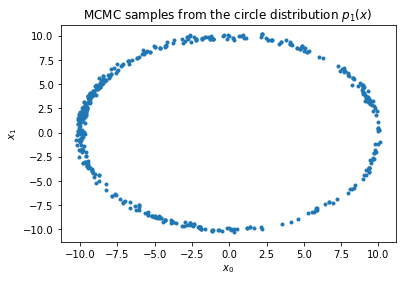

In [18]:
import autograd.numpy as np
from autograd import grad

def lnormpdf(x, y, sigma):
    """Normal log pdf."""
    n = len(x)
    return n/2*np.log(2*np.pi*sigma**2) - 0.5/sigma**2*np.sum((x-y)**2)

def malasample(theta0, n, target, sigma, return_accrate=False):
    """Metropolis-adjusted Langevin algorithm (MALA) sampler."""
    dtarget = grad(target)
    theta = theta0
    d = len(theta0)
    accepts = 0
    lp = target(theta)
    g_theta = dtarget(theta)
    thetas = np.zeros([n, d])
    for i in range(n):
        theta_prop = theta + sigma*npr.normal(size=d) + sigma**2/2 * g_theta
        l_prop = target(theta_prop)
        g_theta_prop = dtarget(theta_prop)
        a = (l_prop - lp 
             + lnormpdf(theta,      theta_prop + sigma**2/2 * g_theta_prop, sigma)
             - lnormpdf(theta_prop, theta      + sigma**2/2 * g_theta,      sigma))
        if  np.log(npr.rand()) < a:
            theta = theta_prop
            lp = l_prop
            g_theta = g_theta_prop
            accepts += 1
        thetas[i] = theta
    if return_accrate:
        return accepts/n
    else:
        print('Acceptance rate:', accepts/n)
        return thetas[len(thetas)//2:]

plt.plot(samples1[:,0], samples1[:,1], '.')
plt.xlabel(r'$x_0$')
plt.ylabel(r'$x_1$')
plt.title(r'MCMC samples from the circle distribution $p_1(x)$')
print('Mean: {}'.format(np.mean(samples1, 0)))
print('Std: {}'.format(np.std(samples1, 0)))

Acceptance rate: 0.5482666666666667


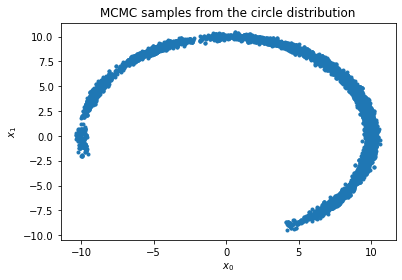

Mean: [6.36841121 1.95206246]
Std: [5.8511791  4.63284184]


In [19]:
# 1
samples1 = malasample(np.array([0.0, 6.0]), 30000, circle, 0.3)
plot_results(samples1,'circle')

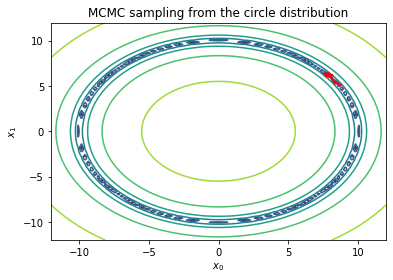

In [20]:
# 1 make video
xlims = (-12, 12)
ylims = (-12, 12)
anim = make_animation(samples1,xlims,ylims,circle,'circle')
HTML(anim.to_html5_video())

Acceptance rate: 0.204


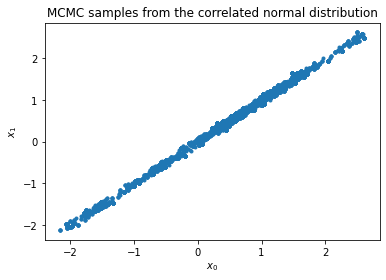

Mean: [0.54402504 0.53970586]
Std: [1.00542513 1.00780542]
Correlation coefficient rho: 0.9978694700171963


In [21]:
# 2
samples2 = malasample(np.array([0.0, 0.0]), 10000, correlated_normal, 0.13)
plot_results(samples2,'correlated normal')
print('Correlation coefficient rho: {}'.format(np.corrcoef(samples2.T)[0,1]))

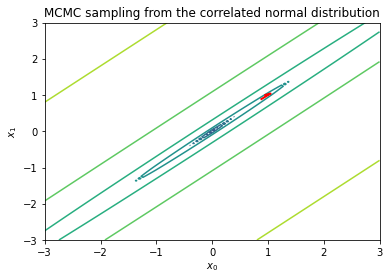

In [22]:
# 2 make video
xlims = (-3, 3)
ylims = (-3, 3)
anim = make_animation(samples2,xlims,ylims,correlated_normal,'correlated normal')
HTML(anim.to_html5_video())

Acceptance rate: 0.48468


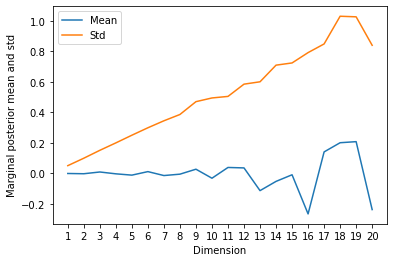

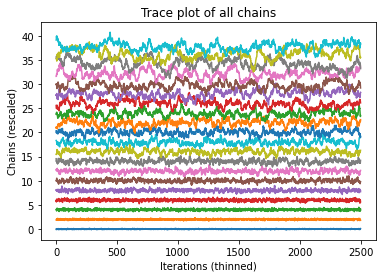

In [23]:
# 3

samples3 = malasample(np.zeros(20), 50000, big_normal, 0.1)

plt.plot(np.arange(1, 21), np.mean(samples3, 0),label='Mean')
plt.plot(np.arange(1, 21), np.std(samples3, 0),label='Std')
plt.xticks(np.arange(1,21))
plt.xlabel('Dimension')
plt.ylabel('Marginal posterior mean and std')
plt.legend()
plt.show()

plt.plot(samples3[::10] + 2*np.arange(20))
plt.xlabel('Iterations (thinned)')
plt.ylabel('Chains (rescaled)')
plt.title('Trace plot of all chains')
plt.show()